# Get multivariate data

### 1. necessary imports & helpers

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from rich.jupyter import display
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
import os

fred_api_key = os.getenv('FRED_API_KEY', default=None)
if fred_api_key is None:
    raise ValueError('You must set a FRED_API_KEY environment variable')

fred = Fred(api_key=fred_api_key)

%matplotlib inline
sns.set_style("darkgrid")

### 2. get series'
   - Real GDP
   - Inflation
   - Short term interest rates
   - Long term interest rates
   - Unemployment

In [5]:
start = '1977-01-01'
fred_series = {
    "GDPC1": "real_gdp",
    "CPIAUCSL": "cpi",
    "TB3MS": "rate_3m",
    "GS10": "rate_10y",
    "UNRATE": "unemployment",
}

raw = pd.DataFrame({
    name: fred.get_series(fid) for fid, name in zip(fred_series, fred_series.values())
})
raw.index.name = "date"
raw

,real_gdp,cpi,rate_3m,rate_10y,unemployment
date,,,,,
1934-01-01,NaN,NaN,0.72,NaN,NaN
1934-02-01,NaN,NaN,0.62,NaN,NaN
1934-03-01,NaN,NaN,0.24,NaN,NaN
1934-04-01,NaN,NaN,0.15,NaN,NaN
1934-05-01,NaN,NaN,0.16,NaN,NaN
...,...,...,...,...,...
2024-12-01,NaN,317.603,4.27,4.39,4.1
2025-01-01,23526.085,319.086,4.21,4.63,4.0
2025-02-01,NaN,319.775,4.22,4.45,4.1


### 3. align to quarterly
   - **GDP** is already quarterly, timestamped at quarter end
   - CPI, rates, unemployment are monthly -> convert to quarterly **mean**

In [7]:
gdp_q = raw["real_gdp"].to_period("Q").to_timestamp("Q")
others_q = (raw.drop(columns=["real_gdp"]).resample("QE").mean())
panel_q = pd.concat([gdp_q, others_q], axis=1)

panel_q.dropna(inplace=True)
panel_q

,real_gdp,cpi,rate_3m,rate_10y,unemployment
date,,,,,
1953-06-30,2919.206,26.720000,2.153333,2.996667,2.566667
1953-09-30,2902.785,26.843333,1.956667,2.916667,2.733333
1953-12-31,2858.845,26.890000,1.473333,2.643333,3.700000
1954-03-31,2845.192,26.953333,1.060000,2.440000,5.266667
1954-06-30,2848.305,26.910000,0.790000,2.346667,5.800000
...,...,...,...,...,...
2024-03-31,23053.545,310.974333,5.233333,4.160000,3.833333
2024-06-30,23223.906,313.095667,5.243333,4.443333,4.000000
2024-09-30,23400.294,314.182667,4.990000,3.946667,4.166667


### 4. transformations:
   - need to apply some sort of transformations to try to reach *some* level of stationarity (which we'll still test after) for each metric:
        - real_gdp: YoY log %
        - cpi: YoY %
        - rate_3m: $\Delta$ level
        - rate_10y: $\Delta$ level
        - unemployment: $\Delta$ level

In [8]:
trans = pd.DataFrame(index=panel_q.index)
trans["gdp_yoy"] = 400 * (np.log(panel_q["real_gdp"]) - np.log(panel_q["real_gdp"].shift(4)))
trans["inf_yoy"] = panel_q["cpi"].pct_change(4) * 100

# first differences
for col in ["rate_3m", "rate_10y", "unemployment"]:
    trans[col + "_d1"] = panel_q[col].diff()

trans.dropna(inplace=True)
trans

,gdp_yoy,inf_yoy,rate_3m_d1,rate_10y_d1,unemployment_d1
date,,,,,
1954-06-30,-9.835032,0.711078,-0.270000,-9.333333e-02,0.533333
1954-09-30,-3.085192,-0.012418,0.093333,-4.440892e-16,0.166667
1954-12-31,10.768225,-0.495847,0.136667,1.266667e-01,-0.633333
1955-03-31,23.949307,-0.593619,0.203333,1.733333e-01,-0.600000
1955-06-30,29.969666,-0.569801,0.260000,1.166667e-01,-0.333333
...,...,...,...,...,...
2024-03-31,11.442103,3.247987,-0.050000,-2.800000e-01,0.033333
2024-06-30,11.966597,3.187395,0.010000,2.833333e-01,0.166667
2024-09-30,10.729869,2.659872,-0.253333,-4.966667e-01,0.166667


### 5. test for stationarity with ADF
- p-values should be ~$< 0.05$ hopefully

In [9]:
adf_results = {}
for col in trans.columns:
    stat, p, *_ = adfuller(trans[col])
    adf_results[col] = {"ADF-stat: ": stat, "p-value": p}

adf_df = pd.DataFrame(adf_results).T
display(adf_df.style.format({"ADF-stat": "{:.2f}", "p-value": "{:.4f}"}))

,ADF-stat:,p-value
gdp_yoy,-3.175918,0.0214
inf_yoy,-1.623975,0.4706
rate_3m_d1,-6.120667,0.0000
rate_10y_d1,-7.581822,0.0000
unemployment_d1,-17.360830,0.0000


^ all weakly-stationary except inflation doesn't pass. I'm ignoring for now because I mainly just want to get to testing the models. Obviously should fix in a more thorough process

<Axes: xlabel='date'>

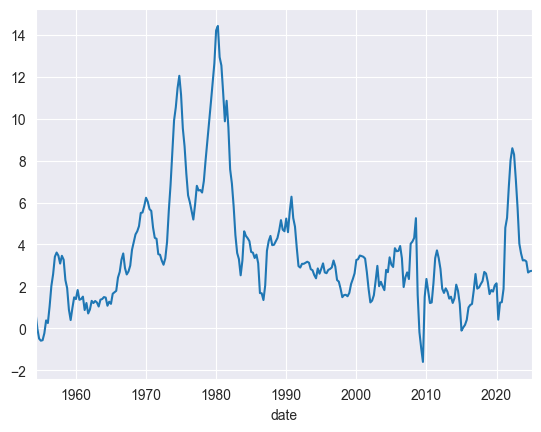

### 6. Z-score standardization

In [11]:
scaler = StandardScaler()
Z = pd.DataFrame(
    scaler.fit_transform(trans),
    index=trans.index,
    columns=trans.columns,
)

Z

,gdp_yoy,inf_yoy,rate_3m_d1,rate_10y_d1,unemployment_d1
date,,,,,
1954-06-30,-2.263432,-1.030420,-0.410992,-0.224637,0.765015
1954-09-30,-1.557446,-1.291299,0.120248,-0.015858,0.243087
1954-12-31,-0.108478,-1.465614,0.183607,0.267484,-0.895664
1955-03-31,1.270170,-1.500869,0.281082,0.371874,-0.848216
1955-06-30,1.899856,-1.492280,0.363936,0.245115,-0.468632
...,...,...,...,...,...
2024-03-31,-0.037995,-0.115659,-0.089324,-0.642194,0.053295
2024-06-30,0.016863,-0.137507,-0.001596,0.617934,0.243087
2024-09-30,-0.112489,-0.327722,-0.386623,-1.126858,0.243087


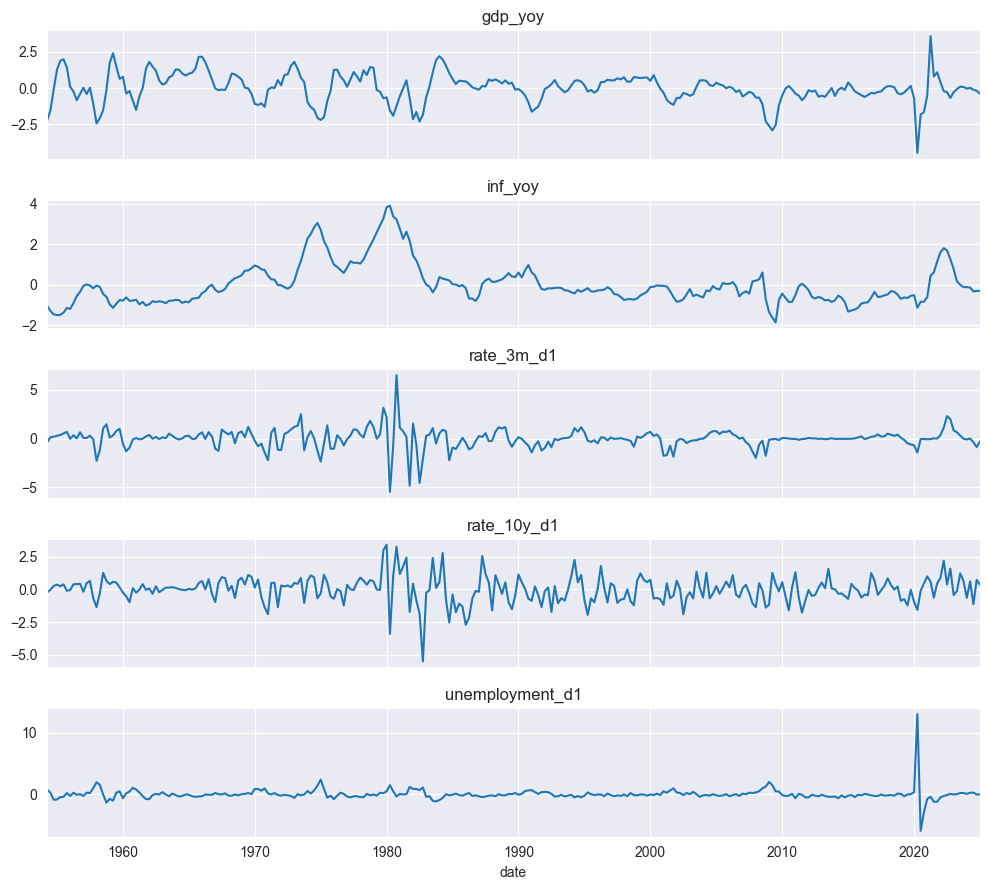

In [13]:
fig, axes = plt.subplots(len(Z.columns), 1, figsize=(10, 9), sharex=True)
for ax, col in zip(axes, Z.columns):
    Z[col].plot(ax=ax)
    ax.set_title(col)
plt.tight_layout()

In [14]:
Z.to_csv("data/macro_panel_standardized.csv")
trans.to_csv("data/macro_panel.csv")
pd.to_pickle(scaler, "data/standard_scaler.pkl")